# Acquiring and Preprocessing Personnel Data from IMDb

This notebook walks through the process of accessing and cleaning data about filmmakers from IMDb-the largest database about the movie industry. The goal is to build a structured dataset of filmmakers involved in core creative roles (directors, writers, producers, cinematographers, editors, composers, and production designers) for movies released between 2000 and 2024. This dataset was used in my PhD dissertation to analyze the career trajectories of filmmakers, the dynamics of their collaboration networks, and the factors that influence their productivity and longevity in the industry.


In [3]:
# import libraries 
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import ast # abstract syntax trees
import math # mathematical operations
from unidecode import unidecode # normalizing unicode characters in strings to their ASCII counterparts
import re # regular expressions
from scipy.stats import ttest_ind # t-test

# Loading Movie Data

First, we load the movie data created in another notebook (`Movie_Data_Acquisition_Cleaning.ipynb`). This dataset contains information about movies released between 2000 and 2024, including the movie title, release year, genres, and the names of the filmmakers involved in the production.

In [ ]:
# Read the movie data created previously, covering all movies from 2000 to 2024
movies_2000_2024 = pd.read_csv('/Users/julie/Library/CloudStorage/OneDrive-McGillUniversity/Work/Datasets/movies_2000_2024.csv')

# Display the first few rows of the dataframe
print(movies_2000_2024.head())

      tconst                                       primaryTitle  \
0  tt0011801                                   Tötet nicht mehr   
1  tt0035423                                     Kate & Leopold   
2  tt0062336  The Tango of the Widower and Its Distorting Mi...   
3  tt0069049                         The Other Side of the Wind   
4  tt0070596                                  Socialist Realism   

                               originalTitle  startYear  runtimeMinutes  \
0                           Tötet nicht mehr       2019             NaN   
1                             Kate & Leopold       2001           118.0   
2  El tango del viudo y su espejo deformante       2020            70.0   
3                 The Other Side of the Wind       2018           122.0   
4                     El realismo socialista       2023            78.0   

                   genres  averageRating  numVotes  
0            Action,Crime            NaN       NaN  
1  Comedy,Fantasy,Romance            6.4

In [10]:
# Examine the data types
movies_2000_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338843 entries, 0 to 338842
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          338843 non-null  object 
 1   primaryTitle    338841 non-null  object 
 2   originalTitle   338841 non-null  object 
 3   startYear       338843 non-null  int64  
 4   runtimeMinutes  263479 non-null  float64
 5   genres          322209 non-null  object 
 6   averageRating   190644 non-null  float64
 7   numVotes        190644 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 20.7+ MB


# Acquiring IMDb Crew Data

IMDb also provides a separate dataset about individuals working on films. Let's pull this data directly from IMDb's servers.

In [5]:
# Define URL for IMDB movie crew data
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Load the data directly from IMDB server
principals = pd.read_csv(url_principals, sep='\t', compression='gzip', low_memory=False)

# Understanding the data structure
print(principals.head())
print("Shape of the dataset:", principals.shape)
print(principals.info())

      tconst  ordering     nconst         category                      job  \
0  tt0000001         1  nm1588970             self                       \N   
1  tt0000001         2  nm0005690         director                       \N   
2  tt0000001         3  nm0005690         producer                 producer   
3  tt0000001         4  nm0374658  cinematographer  director of photography   
4  tt0000002         1  nm0721526         director                       \N   

  characters  
0   ["Self"]  
1         \N  
2         \N  
3         \N  
4         \N  
Shape of the dataset: (91510832, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91510832 entries, 0 to 91510831
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   tconst      object
 1   ordering    int64 
 2   nconst      object
 3   category    object
 4   job         object
 5   characters  object
dtypes: int64(1), object(5)
memory usage: 4.1+ GB
None


The personnel data contains information on people who have worked on movies. Each row is a person-movie pair and the columns contain information on the role they played in the movie.

# Data Cleaning and Filtering

We select filmmakers involved in core creative roles (directors, writers, producers, cinematographers, editors, composers, and production designers).

In [6]:
# Filter the data to include only those in core creative roles
creative_roles = ['director', 'producer', 'writer', 'editor', 'cinematographer', 'production_designer', 'composer']
principals_core_creative = principals[principals['category'].isin(creative_roles)]

# Merge the movies_2000_2024 dataset with the principals_core_creative dataset to include the crew information
movie_creative_crew = pd.merge(
    movies_2000_2024[['tconst', 'startYear']], 
    principals_core_creative[['tconst', 'nconst', 'category']], 
    on='tconst', 
    how="inner"
    )

In [7]:
# Understand the data structure
print(movie_creative_crew.head())
print("Shape of the dataset:", movie_creative_crew.shape)

      tconst  startYear     nconst         category
0  tt0011801       2019  nm0681726         director
1  tt0011801       2019  nm0483944           writer
2  tt0011801       2019  nm0681726           writer
3  tt0011801       2019  nm0681726         producer
4  tt0011801       2019  nm1773808  cinematographer
Shape of the dataset: (2095701, 4)


This data links a movie (`tconst`) to the people who worked on it (`nconst`). So each row is a person-movie pair, and the `category` column tells us what the person did on the movie.

In [8]:
# Examine the data types
movie_creative_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095701 entries, 0 to 2095700
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tconst     object
 1   startYear  int64 
 2   nconst     object
 3   category   object
dtypes: int64(1), object(3)
memory usage: 64.0+ MB


In [9]:
# Count the number of unique values in each column
movie_creative_crew.nunique()

tconst       328453
startYear        25
nconst       670615
category          7
dtype: int64

This data contains information on 670615 creative workers involved in the production of 328453 movies over 25 years (2000 to 2024). So among the 338843 movies released between 2000 and 2024, 97% has information on creative workers (directors, writers, producers, cinematographers, editors, composers, and production designers).

In [12]:
# Display the unique values in the category and startYear columns
print(movie_creative_crew['category'].unique())

['director' 'writer' 'producer' 'cinematographer' 'composer' 'editor'
 'production_designer']


The data has information on the people working in 7 core creative roles (e.g. writer, director, composer) on movies released between 2000 and 2024. 

In [13]:
# Check missing values
print(movie_creative_crew.isnull().sum())

# Identify duplicates
duplicates = movie_creative_crew[movie_creative_crew.duplicated()]
print("Number of duplicate rows:", duplicates.shape[0])


tconst       0
startYear    0
nconst       0
category     0
dtype: int64
Number of duplicate rows: 0


In [14]:
movie_creative_crew.head()

,tconst,startYear,nconst,category
0,tt0011801,2019,nm0681726,director
1,tt0011801,2019,nm0483944,writer
2,tt0011801,2019,nm0681726,writer
3,tt0011801,2019,nm0681726,producer
4,tt0011801,2019,nm1773808,cinematographer


Let's visualize how the size of creative teams has evolved from 2000 to 2024.

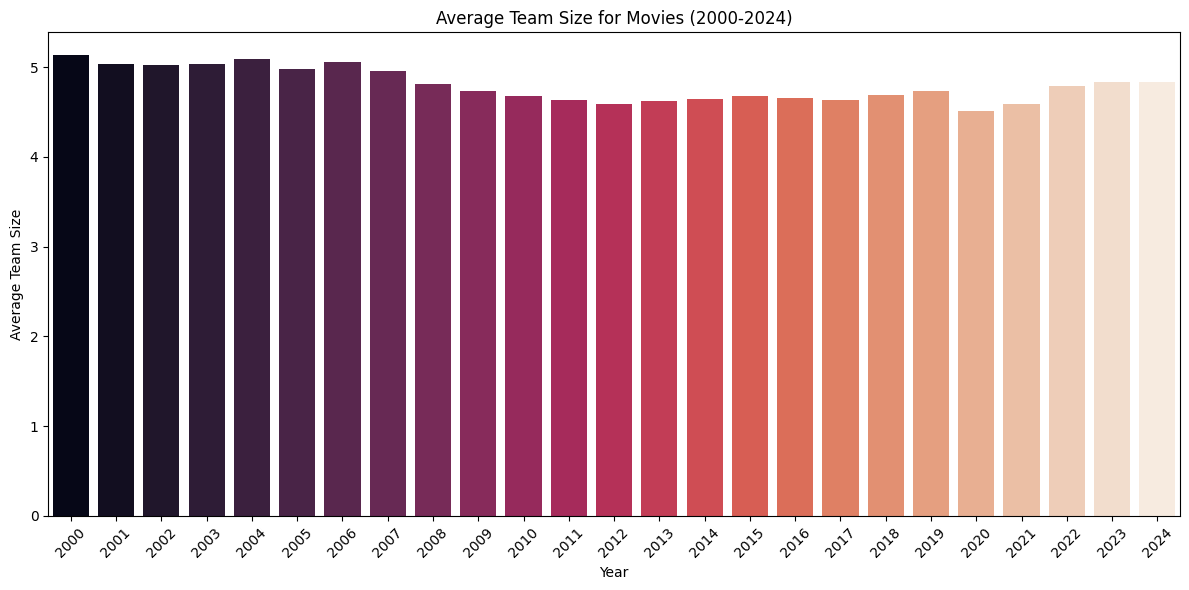

In [15]:
# Group by movie and count the number of unique people in it (team size)
team_size_per_movie = movie_creative_crew.groupby('tconst')['nconst'].nunique().reset_index(name='team_size')

# Merge the team size data with the movies_2000_2024 dataset to get the startYear
team_size_per_movie = pd.merge(team_size_per_movie, movies_2000_2024[['tconst', 'startYear']], on='tconst', how='left')

# Calculate the average team size for movies for each year
avg_team_size_per_year = team_size_per_movie.groupby('startYear')['team_size'].mean().reset_index()

# Plot the average team size for movies for each year as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_team_size_per_year,
    x='startYear',
    y='team_size',
    hue='startYear',        # assign x variable as hue
    palette="rocket",
    dodge=False
)
plt.xlabel('Year')
plt.ylabel('Average Team Size')
plt.title('Average Team Size for Movies (2000-2024)')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)  # hide the legend
plt.tight_layout()
plt.show()

In [18]:
# save movie_creative_crew
movie_creative_crew.to_csv('movie_creative_crew_2000_2024.csv', index=False)

# Accessing Filmmaker Personal Data

IMDb provides information about the filmmakers themselves (like their names and birth year). Let's pull this data directly from IMDb's servers.

In [19]:
# Define the URL for the IMDb dataset that contains names of film industry professionals
url_name = 'https://datasets.imdbws.com/name.basics.tsv.gz'
# Load the dataset using the URL
names = pd.read_csv(url_name, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

# Understanding the data structure
print(names.head())
print("Shape of the dataset:", names.shape)
print("Data types:", names.info())

      nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                    primaryProfession                           knownForTitles  
0        actor,miscellaneous,producer  tt0072308,tt0050419,tt0027125,tt0031983  
1  actress,soundtrack,archive_footage  tt0037382,tt0075213,tt0038355,tt0117057  
2   actress,music_department,producer  tt0057345,tt0049189,tt0056404,tt0054452  
3       actor,writer,music_department  tt0072562,tt0077975,tt0080455,tt0078723  
4               writer,director,actor  tt0050986,tt0069467,tt0050976,tt0083922  
Shape of the dataset: (14264702, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264702 entries, 0 to 14264701
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------   

# Extracting Filmmaker First Names and Calculating their Productivity

Finally, we extract the first names of the filmmakers. This will help us predict their gender in the next step. 

We also compute how many movies each filmmaker has worked on. This metric (movie count) gives us insight into their productivity and can later help us build a model predicting who will have a long, prolific career and who will drop out of the industry prematurely.

In [ ]:
# Filter the names DataFrame
creatives_2000_2024 = names[names['nconst'].isin(movie_creative_crew['nconst'])].copy()

# Convert birthYear and deathYear to numeric
creatives_2000_2024['birthYear'] = pd.to_numeric(creatives_2000_2024['birthYear'], errors='coerce')
creatives_2000_2024['deathYear'] = pd.to_numeric(creatives_2000_2024['deathYear'], errors='coerce')

In [ ]:

# Convert primaryName to string
creatives_2000_2024['primaryName'] = creatives_2000_2024['primaryName'].astype(str)

# Convert unicode characters to their closest ASCII representation
# Split the 'primaryName' by space and selecting the first element isolates the first name
creatives_2000_2024['first_name'] = creatives_2000_2024['primaryName'].apply(unidecode).apply(lambda x: x.split()[0])

# Count the number of movies each unique person (nconst) has worked on
movies_per_person = movie_creative_crew['nconst'].value_counts().reset_index()
movies_per_person.columns = ['nconst', 'movie_count']

# Merge the count with the creatives_2000_2024 DataFrame
creatives_2000_2024 = pd.merge(creatives_2000_2024, movies_per_person, on='nconst', how='left')

# Display the first few rows of the updated DataFrame
creatives_2000_2024.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,first_name,movie_count
0,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922",Ingmar,3
1,nm0000016,Georges Delerue,1925.0,1992.0,"composer,music_department,actor","tt0091763,tt0096320,tt0069946,tt0079477",Georges,3
2,nm0000018,Kirk Douglas,1916.0,2020.0,"actor,producer,director","tt0043338,tt0080736,tt0054331,tt0049456",Kirk,1
3,nm0000019,Federico Fellini,1920.0,1993.0,"writer,director,actor","tt0056801,tt0050783,tt0047528,tt0053779",Federico,1
4,nm0000025,Jerry Goldsmith,1929.0,2004.0,"music_department,composer,miscellaneous","tt0119488,tt0077269,tt0112715,tt0117731",Jerry,7


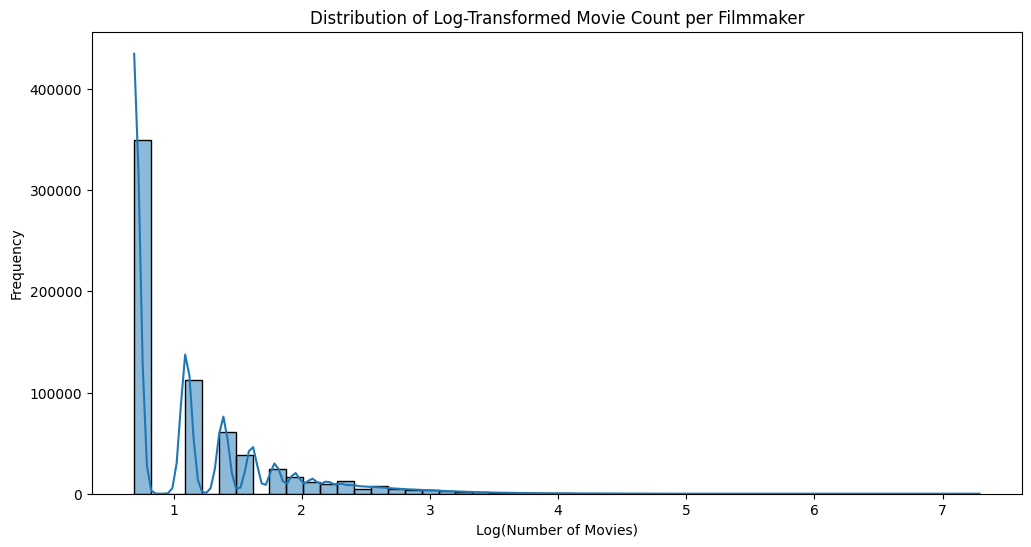

In [24]:
# Apply log transformation to the movie_count column
creatives_2000_2024['log_movie_count'] = np.log1p(creatives_2000_2024['movie_count'])

# Plot the log-transformed movie count
plt.figure(figsize=(12, 6))
sns.histplot(creatives_2000_2024['log_movie_count'], bins=50, kde=True)
plt.xlabel('Log(Number of Movies)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Movie Count per Filmmaker')
plt.show()

In [25]:
# Compute descriptive statistics for movie_count
creatives_2000_2024['movie_count'].describe()

count    670605.000000
mean          3.125075
std           6.249070
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1462.000000
Name: movie_count, dtype: float64

On average, a creative worker has worked on about 3 movies. More than half have only worked on one movie, and 75% have worked on 3 or fewer movies. This indicates that most creative workers are not prolific and have only worked on a few movies between 2000 and 2024. However, the high standard deviation and high maximum value indicate that there are some creative workers who have worked on a large number of movies. This follows the pareto principle, where a small number of creative workers are responsible for a large number of movies.

In [22]:
# Save the creatives_2000_2024 DataFrame to a CSV file
creatives_2000_2024.to_csv('creatives_2000_2024.csv', index=False)